# Кластеризация и бинарная классификация текста

Необходимо разработать программу, обеспечивающую кластеризацию новостного потока. Необходимо загрузить новостную ленту, выделив из нее тематические пометы (при наличии). Далее следует векторизовать тексты, провести их кластеризацию и проверить точность кластеризации по тематическим пометам. Также следует выбрать один из кластеров и обучить на нем классификатор. Точность работы классификатора определяется при помощи f1-меры и матрицы ошибок.


In [181]:
import re
from tqdm import tqdm
import pandas as pd
import csv
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 8)

In [182]:
from google.colab import drive
drive.mount('/content/drive')
news0 = '/content/drive/MyDrive/Colab_Notebooks/data/news(1).csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
news = pd.read_csv(news0)

## Разведочный анализ данных

Для начала посмотрим как выглядят данные.

In [184]:
print(news.head())

                                              aTitle  \
0  С подачи шаманов. Ритуалы с употреблением галл...   
1  Куда и откуда. О миграции древних людей расска...   
2  Окончательно и бесповоротно? Предотвратить рец...   
3  Жжет светило. Наблюдения космического аппарата...   
4  Меняется обмен. Уникальный атлас отразил проце...   

                                        categories  \
0    ['Новости', 'В мире', 'Статьи', 'Археология']   
1    ['Новости', 'В мире', 'Статьи', 'Археология']   
2      ['Новости', 'В мире', 'Статьи', 'Медицина']   
3        ['Новости', 'В мире', 'Статьи', 'Космос']   
4  ['Новости', 'В России', 'Статьи', 'Социология']   

                                           anArticle  
0  Анализ пряди волос из могильника на испанском ...  
1  В мае в Таджикистане состоится масштабная эксп...  
2  Новая противораковая вакцина, подогнанная под ...  
3  В марте прошлого года, спустя несколько месяце...  
4  Уезжают, приезжают, перемещаются… Добровольно,...  


In [185]:
print(news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   aTitle      1949 non-null   object
 1   categories  1949 non-null   object
 2   anArticle   1928 non-null   object
dtypes: object(3)
memory usage: 45.8+ KB
None


In [186]:
# Удаление строк, где categories равен None
news = news[news['anArticle'].notna()]

Посмотрим какие у нас категории

In [187]:
# Преобразуем строки в списки
news['categories'] = news['categories'].apply(ast.literal_eval)

In [188]:
print(news.categories.head(10))

0                [Новости, В мире, Статьи, Археология]
1                [Новости, В мире, Статьи, Археология]
2                  [Новости, В мире, Статьи, Медицина]
3                    [Новости, В мире, Статьи, Космос]
4              [Новости, В России, Статьи, Социология]
5                [Новости, В России, Статьи, Медицина]
6    [Международное сотрудничество, Новости, В Росс...
7                  [Новости, В России, Статьи, Память]
8              [Новости, В России, Статьи, Математика]
9      [Новости, В России, РАН, Статьи, Юриспруденция]
Name: categories, dtype: object


In [189]:
# Распределение новостей по категориям
# Создаем список всех категорий
all_categories = [category for sublist in news['categories'] for category in sublist]

# Создаем DataFrame для подсчета категорий
category_counts = pd.Series(all_categories).value_counts()

# Выводим распределение новостей по категориям
print("Распределение новостей по категориям:")
print(category_counts.head(20))

Распределение новостей по категориям:
Статьи                          1906
Новости                         1773
В России                        1102
В мире                           341
Медицина                         185
Образование                      176
Космос                           132
Биология                         128
научная политика                 122
РАН                              103
Коронавирус                       94
Физика                            92
Археология                        62
История                           59
Территория науки                  52
Международное сотрудничество      51
Генетика                          50
Экология                          47
Климат                            42
Техно                             40
Name: count, dtype: int64


Очевидна подавляющая доминация категорий 'Новости', 'Статьи', 'В России', 'В мире'. Вообще категории Новости и Статьи имеют практически все данные. Избавимся от неинформативных признаков. Также нам нет разницы описывает новость только Россию или весь мир

In [190]:
# Категории, которые нужно удалить
categories_to_remove = ['Новости', 'Статьи', 'В России', 'В мире']

# Функция для очистки категорий
def clean_categories(categories):
    return [category for category in categories if category not in categories_to_remove]

# Создание нового столбца categories_cleaned
news['categories_cleaned'] = news['categories'].apply(clean_categories)

# Вывод результата
print(news.categories_cleaned.head(10))

0                      [Археология]
1                      [Археология]
2                        [Медицина]
3                          [Космос]
4                      [Социология]
5                        [Медицина]
6    [Международное сотрудничество]
7                          [Память]
8                      [Математика]
9              [РАН, Юриспруденция]
Name: categories_cleaned, dtype: object


Видно, что у последней новости две категории. Посмотрим сколько осталось новостей, у которых более одной категории. Также выясним сколько новостей остались вообще без категорий

In [191]:
# Подсчет общего количества категорий
all_categories = [category for sublist in news['categories_cleaned'] for category in sublist]
unique_categories = set(all_categories)
num_unique_categories = len(unique_categories)

# Подсчет количества новостей с более чем одной категорией
num_news_multiple_categories = news[news['categories_cleaned'].apply(len) > 1].shape[0]

# Подсчет количества новостей без категорий
num_news_without_categories = news[news['categories_cleaned'].apply(len) == 0].shape[0]

# Вывод результатов
print(f"Общее количество уникальных категорий: {num_unique_categories}")
print(f"Количество новостей с более чем одной категорией: {num_news_multiple_categories}")
print(f"Количество новостей без категорий: {num_news_without_categories}")

Общее количество уникальных категорий: 82
Количество новостей с более чем одной категорией: 238
Количество новостей без категорий: 223


Посмотрим на распределение новостей по категории

<ipython-input-192-bb52f54356cf>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts_df, x='Category', y='Count', palette='viridis')


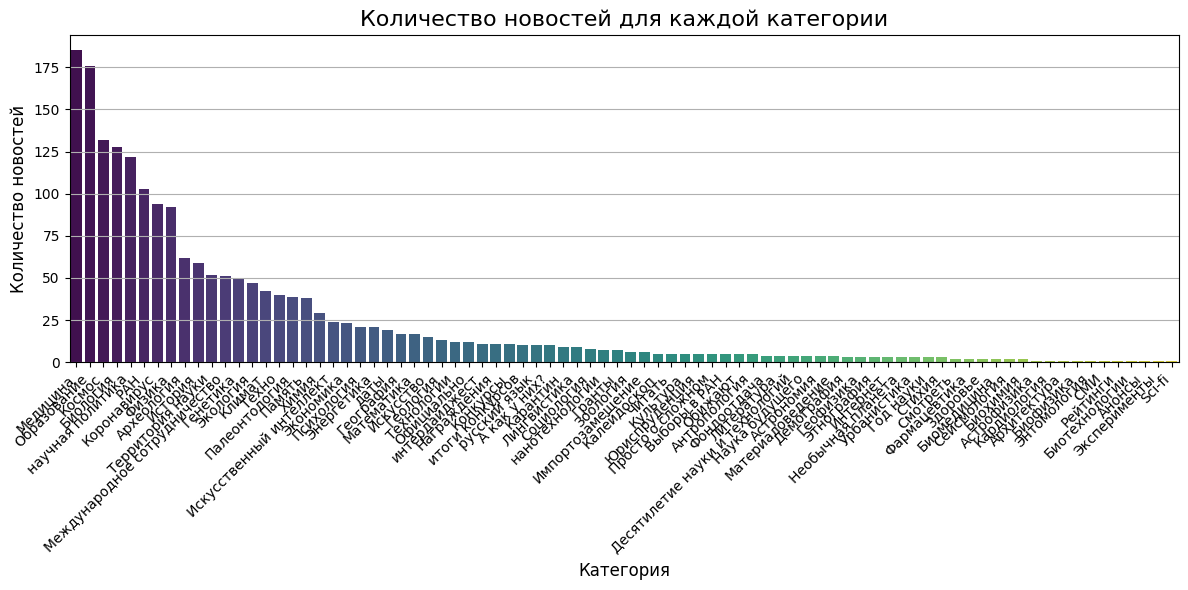

In [192]:
all_categories = [category for sublist in news['categories_cleaned'] for category in sublist]

# Создаем DataFrame для подсчета категорий
category_counts = pd.Series(all_categories).value_counts()

# Преобразуем результат в датафрейм для удобства работы
category_counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

# Сортируем категории по количеству новостей в порядке убывания
category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
sns.barplot(data=category_counts_df, x='Category', y='Count', palette='viridis')

# Добавляем заголовок и подписи осей
plt.title('Количество новостей для каждой категории', fontsize=16)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.grid(axis='y')
# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Отображаем график
plt.tight_layout()  # Автоматически корректирует отступы
plt.show()

Категорий слишком много для нормальной кластеризации. Тем хуже что очень много категорий имеют небольшое число новостей

Изучим какие новости лишились категории в процессе чистки. Возможно их можно заменить какой-то одной категорией или куда нибудь добавить

In [193]:
# Фильтруем новости, у которых categories_cleaned пустое
empty_categories_cleaned = news[news['categories_cleaned'].apply(len) == 0]

# Преобразуем списки в кортежи для возможности группировки
empty_categories_cleaned['categories_tuple'] = empty_categories_cleaned['categories'].apply(tuple)

# Группируем новости по уникальным значениям categories и считаем их количество
category_counts = (
    empty_categories_cleaned
    .groupby('categories_tuple')
    .size()
    .reset_index(name='count')
)

# Переименовываем столбец обратно в 'categories' для удобства чтения
category_counts['categories'] = category_counts['categories_tuple'].apply(list)
category_counts = category_counts[['categories', 'count']]

# Выводим результат
print(category_counts.sort_values(by="count", ascending=False))

                    categories  count
4                     [Статьи]    115
3            [Новости, Статьи]     69
1  [Новости, В России, Статьи]     25
2    [Новости, В мире, Статьи]     11
0             [В мире, Статьи]      3


<ipython-input-193-775d27d3b373>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_categories_cleaned['categories_tuple'] = empty_categories_cleaned['categories'].apply(tuple)


Нет, найденные категории слишком общие. С данными новостями придется расстаться.

Тогда посмотрим на новости у которых более чем одна категория

In [194]:
# Фильтруем новости, у которых categories_cleaned содержит более одной категории
news_multiple_categories = news[news['categories_cleaned'].apply(len) > 1]

# Преобразуем списки в кортежи для возможности группировки
news_multiple_categories['categories_tuple'] = news_multiple_categories['categories_cleaned'].apply(tuple)

# Группируем новости по уникальным значениям categories_cleaned и считаем их количество
category_counts = (
    news_multiple_categories
    .groupby('categories_tuple')
    .size()
    .reset_index(name='count')
)

# Переименовываем столбец обратно в 'categories_cleaned' для удобства чтения
category_counts['categories_cleaned'] = category_counts['categories_tuple'].apply(list)
category_counts = category_counts[['categories_cleaned', 'count']]

# Выводим результат
print(category_counts.sort_values(by="count", ascending=False).head(20))

                                   categories_cleaned  count
101                           [РАН, научная политика]     22
10                               [Биология, Медицина]     16
84                               [Официально, Память]     10
40                            [Коронавирус, Медицина]      9
75                         [Образование, Коронавирус]      6
43                                 [Коронавирус, РАН]      5
13                               [Биология, Экология]      4
15                               [Генетика, Медицина]      4
8                                 [Биология, История]      4
107                                 [Химия, Медицина]      4
62        [Международное сотрудничество, Коронавирус]      3
111                                [Экология, Климат]      3
68   [Международное сотрудничество, научная политика]      3
114                             [Экология, Экономика]      3
80                                 [Образование, РАН]      3
74                      

<ipython-input-194-9501fa88d65d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_multiple_categories['categories_tuple'] = news_multiple_categories['categories_cleaned'].apply(tuple)


Имеем странные категории как "Официально", а также слишком общие вроде "Коронавирус". В таком случае просто оставим более распространенную категорию, а остальные, более редкие, удалим

In [195]:
# Подсчет частоты категорий
all_categories = [category for sublist in news['categories_cleaned'] for category in sublist]
category_counts = pd.Series(all_categories).value_counts()

# Функция для выбора самой частой категории из списка
def select_most_frequent_category(categories):
    if len(categories) == 1:  # Если категория одна, возвращаем её
        return [categories[0]]
    # Находим категорию с максимальной частотой
    if len(categories) == 0:
      return []
    most_frequent_category = max(categories, key=lambda cat: category_counts.get(cat, 0))
    return [most_frequent_category]

# Создаем новый столбец с самой частой категорией
news['categories_cleaned_rare'] = news['categories_cleaned'].apply(select_most_frequent_category)

In [196]:
# Подсчет общего количества категорий
all_categories = [category for sublist in news['categories_cleaned_rare'] for category in sublist]
unique_categories = set(all_categories)
num_unique_categories = len(unique_categories)

# Подсчет количества новостей с более чем одной категорией
num_news_multiple_categories = news[news['categories_cleaned_rare'].apply(len) > 1].shape[0]

# Подсчет количества новостей без категорий
num_news_without_categories = news[news['categories_cleaned_rare'].apply(len) == 0].shape[0]

# Вывод результатов
print(f"Общее количество уникальных категорий: {num_unique_categories}")
print(f"Количество новостей с более чем одной категорией: {num_news_multiple_categories}")
print(f"Количество новостей без категорий: {num_news_without_categories}")

Общее количество уникальных категорий: 76
Количество новостей с более чем одной категорией: 0
Количество новостей без категорий: 223


Несколько категорий исчезли вообще. Посмотрим как изменился график

<ipython-input-197-940c909d1204>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts_df, x='Category', y='Count', palette='viridis')


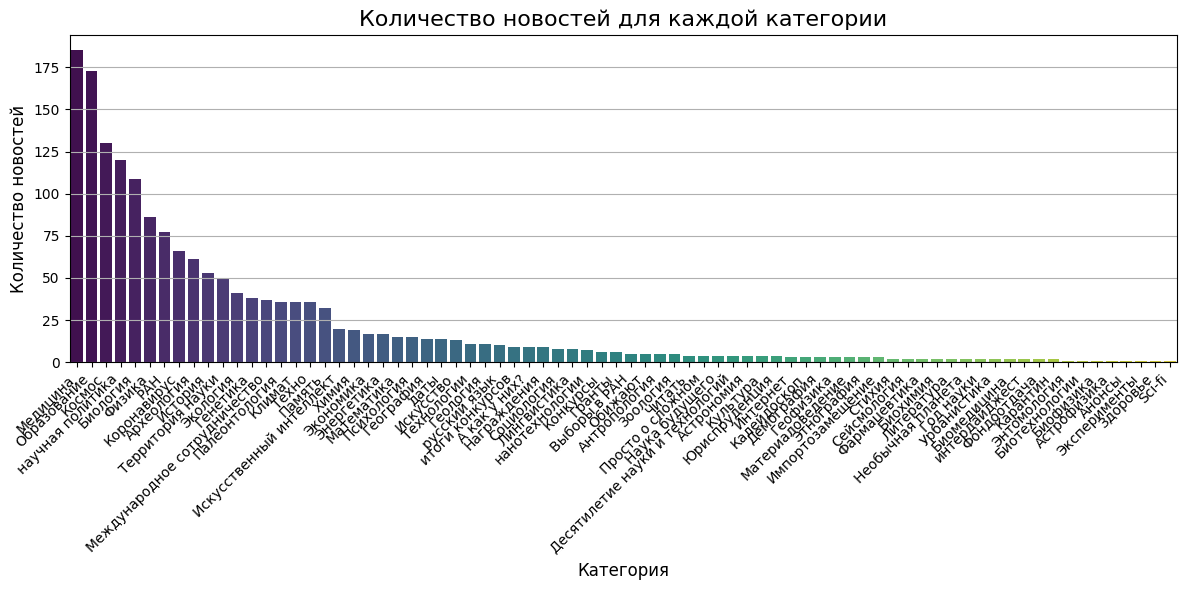

In [197]:
all_categories = [category for sublist in news['categories_cleaned_rare'] for category in sublist]

# Создаем DataFrame для подсчета категорий
category_counts = pd.Series(all_categories).value_counts()

# Преобразуем результат в датафрейм для удобства работы
category_counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

# Сортируем категории по количеству новостей в порядке убывания
category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
sns.barplot(data=category_counts_df, x='Category', y='Count', palette='viridis')

# Добавляем заголовок и подписи осей
plt.title('Количество новостей для каждой категории', fontsize=16)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.grid(axis='y')
# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Отображаем график
plt.tight_layout()  # Автоматически корректирует отступы
plt.show()

Очевидных изменений мало, редкие категории стали еще более редкими. Ограничим количество текстов на категорию числом 25, проведем кластеризацию на классах, которые более-менее распространены

In [198]:
from collections import Counter

# Подсчитываем количество вхождений каждой категории
category_counts = Counter(all_categories)

# Разделяем категории на две группы: < 25 и >= 25
categories_less_than_25 = {category: count for category, count in category_counts.items() if count < 25}
categories_25_or_more = {category: count for category, count in category_counts.items() if count >= 25}

# Выводим результаты
print(f"Количество уникальных категорий с числом новостей < 25: {len(categories_less_than_25)}")
print(f"Количество уникальных категорий с числом новостей >= 25: {len(categories_25_or_more)}")

Количество уникальных категорий с числом новостей < 25: 58
Количество уникальных категорий с числом новостей >= 25: 18


In [199]:
# Подсчет частоты категорий
all_categories = [category for sublist in news['categories_cleaned'] for category in sublist]
category_counts = pd.Series(all_categories).value_counts()

# Определяем порог для редких категорий
min_frequency = 25

# Создаем множество допустимых категорий
common_categories = set(category_counts[category_counts >= min_frequency].index)

# Функция для фильтрации категорий
def filter_categories(categories):
    return [cat for cat in categories if cat in common_categories]

# Применяем фильтрацию к столбцу categories_cleaned
news['categories_final'] = news['categories_cleaned'].apply(filter_categories)

# Удаляем новости, у которых после фильтрации не осталось категорий
filtered_news = news[news['categories_final'].apply(len) > 0].reset_index(drop=True)

In [200]:
print(filtered_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   aTitle                   1385 non-null   object
 1   categories               1385 non-null   object
 2   anArticle                1385 non-null   object
 3   categories_cleaned       1385 non-null   object
 4   categories_cleaned_rare  1385 non-null   object
 5   categories_final         1385 non-null   object
dtypes: object(6)
memory usage: 65.1+ KB
None


Число данных значительно уменьшилось, но проводить кластеризацию на 76 категорий, у большинства из которых менее 25 примеров, было бы слишком сложно. Взглянем на итоговый график

<ipython-input-201-4c602e3a20c1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts_df, x='Category', y='Count', palette='viridis')


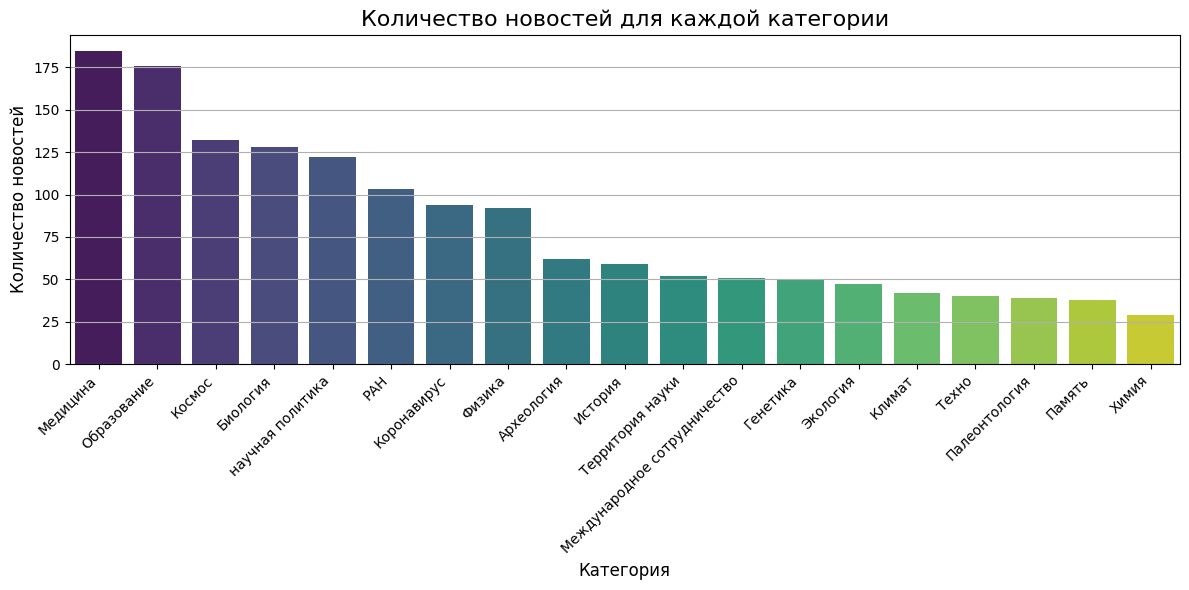

In [201]:
all_categories = [category for sublist in filtered_news['categories_final'] for category in sublist]

# Создаем DataFrame для подсчета категорий
category_counts = pd.Series(all_categories).value_counts()

# Преобразуем результат в датафрейм для удобства работы
category_counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

# Сортируем категории по количеству новостей в порядке убывания
category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
sns.barplot(data=category_counts_df, x='Category', y='Count', palette='viridis')

# Добавляем заголовок и подписи осей
plt.title('Количество новостей для каждой категории', fontsize=16)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.grid(axis='y')
# Поворачиваем метки на оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Отображаем график
plt.tight_layout()  # Автоматически корректирует отступы
plt.show()

Тексты надо векторизовать. Ограничим их длину в 2900 символов, это примерно 500 слов для русского языка

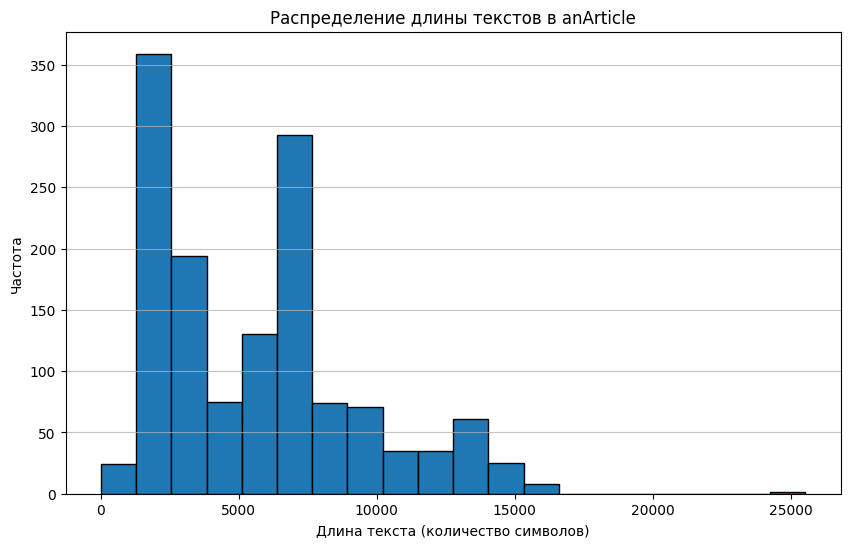

In [202]:
# Вычисление длины текстов в anArticle
filtered_news['title_length'] = filtered_news['anArticle'].str.len()

# Построение гистограммы распределения длины текстов
plt.figure(figsize=(10, 6))
plt.hist(filtered_news['title_length'], bins=20, edgecolor='black')
plt.title('Распределение длины текстов в anArticle')
plt.xlabel('Длина текста (количество символов)')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [203]:
def truncate_text(text, max_length=2900):
    return text[:max_length]

filtered_news['truncated_article'] = filtered_news['anArticle'].apply(truncate_text)

## Пробуем разные способы кластеризации

Используем две метрики:

1.  Adjusted Rand Index (ARI):
Значение ARI лежит в диапазоне от -1 до 1.
* 1 : Идеальное совпадение кластеров с истинными метками.
* 0 : Кластеры случайны и не связаны с истинными метками.
* < 0 : Кластеры хуже, чем случайное разбиение.

2. Normalized Mutual Information (NMI):
Значение NMI также лежит в диапазоне от 0 до 1.
* 1 : Идеальное совпадение.
* 0 : Нет связи между кластерами и истинными метками.


Используем для векторизации простой метод TF-IDF

In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2900)
X = vectorizer.fit_transform(filtered_news['truncated_article'])

### KMeans

   • Описание: Это один из самых популярных алгоритмов кластеризации, который делит данные на K кластеров, минимизируя внутрикластерные вариации.

   • Принцип работы: Алгоритм случайным образом инициализирует K центров кластеров, затем итеративно присваивает точки к ближайшему центру и обновляет центры на основе новых принадлежностей.

   • Плюсы: Простота и скорость.

   • Минусы: Требует заранее знать количество кластеров, чувствителен к выбросам и начальной инициализации.

In [205]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Создаем плоский список всех категорий
all_categories = [category for sublist in filtered_news['categories_final'] for category in sublist]

# Создаем множество уникальных категорий
unique_categories = set(all_categories)

# Количество кластеров равно количеству уникальных категорий
num_clusters = len(unique_categories)

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Подсчитываем частоту категорий
all_categories = [category for sublist in filtered_news['categories_final'] for category in sublist]
category_counts = pd.Series(all_categories).value_counts()

# Функция для выбора самой частой категории из списка
def select_most_frequent_category(categories):
    return max(categories, key=lambda cat: category_counts.get(cat, 0))

# Создаем новый столбец с одной категорией
filtered_news['main_category'] = filtered_news['categories_final'].apply(select_most_frequent_category)


ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.19807856188581266
Normalized Mutual Information: 0.40804351239749237


Метрики достаточно плохие. Это конечно лучше случайного разделения, но все равно не очень

Визуализируем получившиеся кластеры

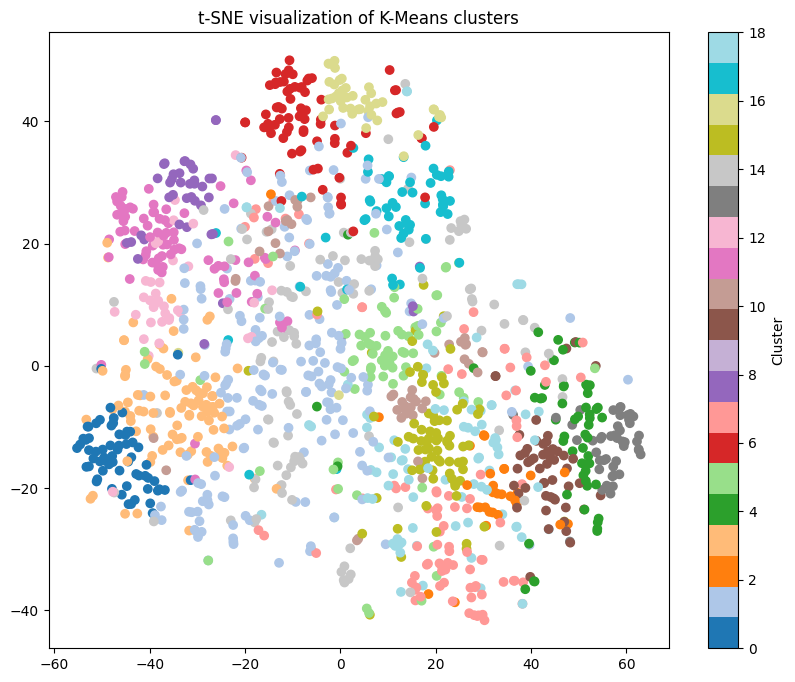

In [122]:
from sklearn.manifold import TSNE

# Применяем t-SNE для понижения размерности
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab20', alpha=1.0)
plt.title("t-SNE visualization of K-Means clusters")
plt.colorbar(label="Cluster")
plt.show()

Попробуем также UMAP

In [125]:
!pip install -q umap-learn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


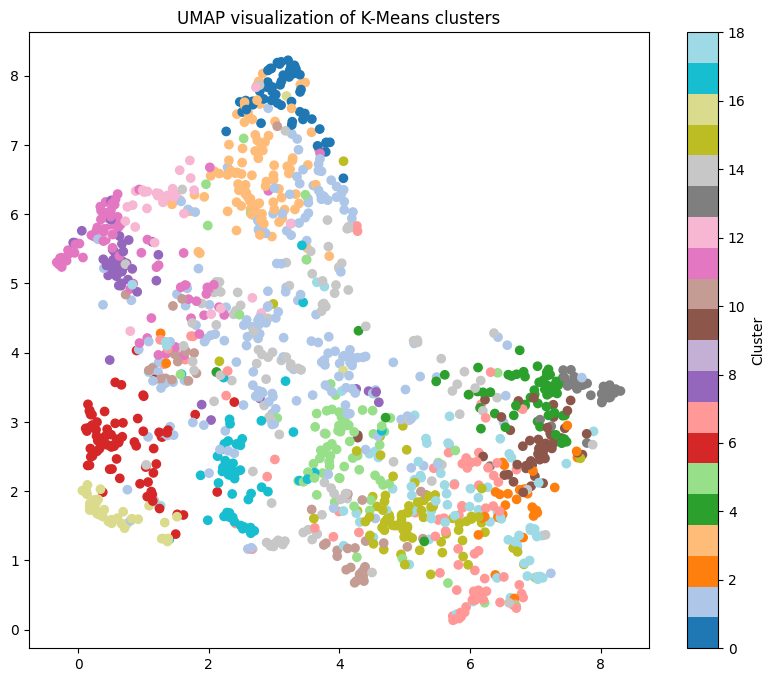

In [129]:
from umap import umap_ as UMAP

# Применяем UMAP для понижения размерности
umap = UMAP.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X.toarray())

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab20', alpha=1.0)
plt.title("UMAP visualization of K-Means clusters")
plt.colorbar(label="Cluster")
plt.show()

Кластеры сильно перемешаны, какие-то приемлемые результаты только на окраинах

Посмотрим где мы больше всего ошибаемся

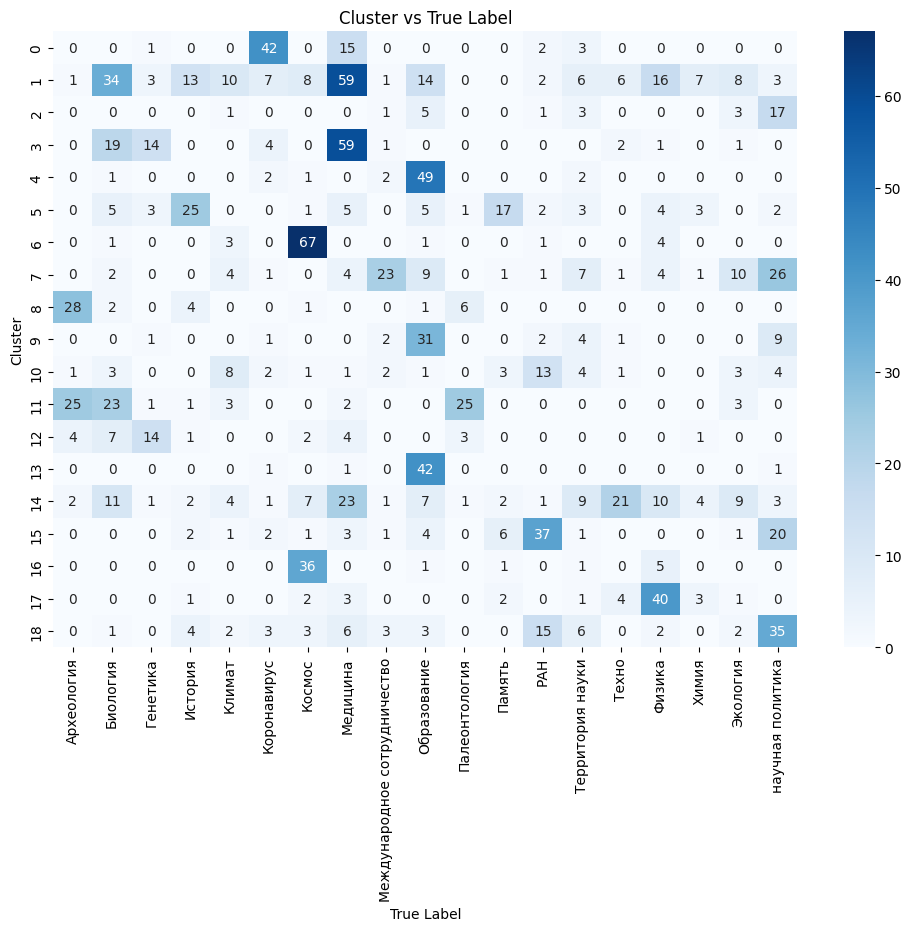

In [206]:
# Создаем DataFrame для анализа ошибок
error_analysis = pd.DataFrame({
    'True_Label': filtered_news['main_category'],
    'Cluster': clusters
})

# Группируем данные по кластерам и истинным меткам
cluster_label_counts = error_analysis.groupby(['Cluster', 'True_Label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_label_counts, annot=True, fmt='d', cmap='Blues')
plt.title("Cluster vs True Label")
plt.xlabel("True Label")
plt.ylabel("Cluster")
plt.show()

Видно, что большую часть истинных меток разделили на два-три кластера. Это можно объяснить тем, Медицина очень связана с Генетикой, она связана с Биологией, она с Климатом и так далее. У нас слишком взаимосвязанные категории новостей. Территория науки и научная политика вообще чрезвычайно общие темы. Коронавирус выделен неплохо, скорее всего из-за уникального слова "Коронавирус". Более менее неплохо выделены Палеонтология и Память. Кластеры 1, 11 и 14 включают в себя практически все категории

### SpectralClustering

   • Описание: Этот алгоритм использует спектральные свойства матрицы смежности графа, чтобы выполнить кластеризацию.

   • Принцип работы: Создает граф на основе расстояний между точками, вычисляет собственные векторы матрицы Лапласа и использует их для проекции данных в пространство меньшей размерности, где применяется K-means.

   • Плюсы: Хорошо справляется с неформальными формами кластеров.

   • Минусы: Вычислительно затратный, требует выбора числа кластеров.

In [143]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=num_clusters, random_state=42)
clusters = spectral.fit_predict(X.toarray())  # Spectral требует плотной матрицы

# Оценка качества
ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.21426471150168727
Normalized Mutual Information: 0.4214442106917804


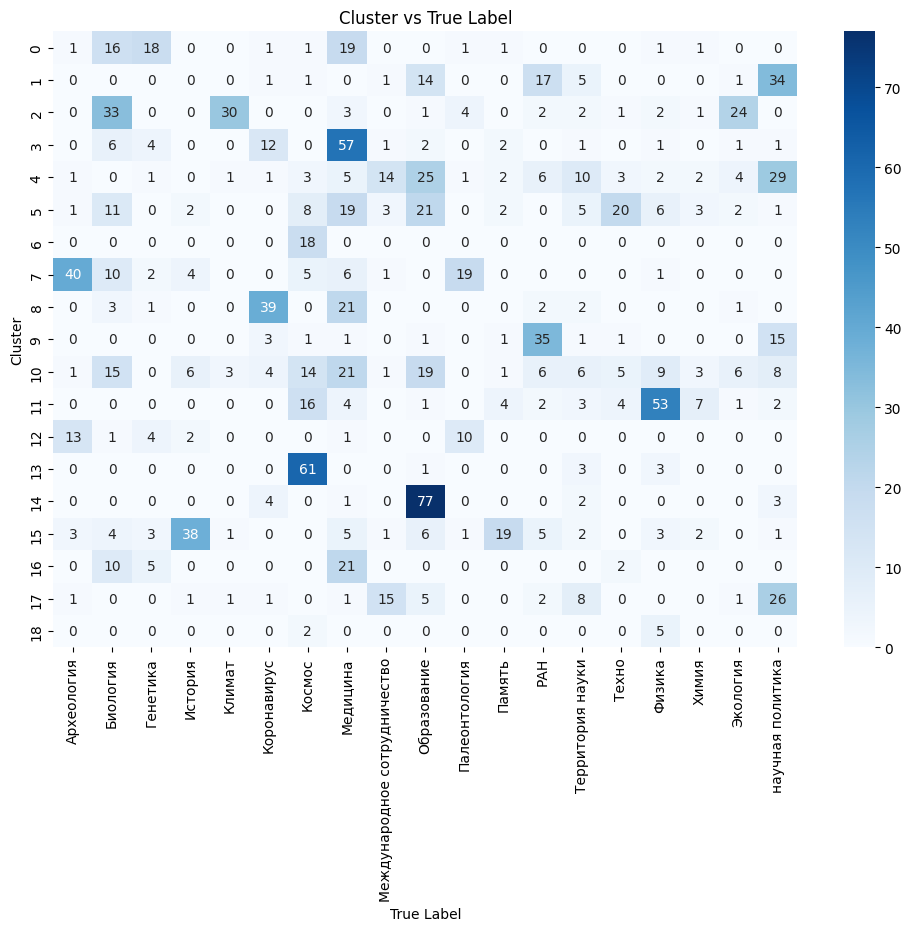

In [144]:
# Создаем DataFrame для анализа ошибок
error_analysis = pd.DataFrame({
    'True_Label': filtered_news['main_category'],
    'Cluster': clusters
})

# Группируем данные по кластерам и истинным меткам
cluster_label_counts = error_analysis.groupby(['Cluster', 'True_Label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_label_counts, annot=True, fmt='d', cmap='Blues')
plt.title("Cluster vs True Label")
plt.xlabel("True Label")
plt.ylabel("Cluster")
plt.show()

Метрики чуть получше, но принципиально картина не изменилась. Кластеры стали с одной стороны более выраженными, теперь Медицина и Образование имеют свой "якорный" кластер, но с другой стороны вместо 2-3 четких мы имеем один четкий и кучу расплывшихся неуверенных кластеров

### AgglomerativeClustering

   • Описание: Это метод, который строит иерархию кластеров путем последовательного объединения.

   • Принцип работы: Начинает с каждой точки как отдельного кластера и последовательно объединяет ближайшие кластеры до достижения заданного числа или порога.

   • Плюсы: Не требует заранее заданного числа кластеров, можно визуализировать в виде дендрограммы.

   • Минусы: Может быть медленным для больших наборов данных, чувствителен к выбору метрики расстояния.

In [146]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agg_clustering.fit_predict(X.toarray())

# Оценка качества
ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.18468103480813364
Normalized Mutual Information: 0.4122775331114859


Метрики стали хуже чем в Kmeans

### DBSCAN


   • Описание: Алгоритм, основанный на плотности, который группирует точки, находящиеся близко друг к другу, и помечает разреженные области как шум.

   • Принцип работы: Определяет кластеры на основе плотности точек; если точка имеет достаточное количество соседей в заданном радиусе, она считается частью кластера.

   • Плюсы: Не требует задания количества кластеров заранее, хорошо справляется с шумом и неформальными формами кластеров.

   • Минусы: Чувствителен к выбору параметров (радиус и минимальное количество точек).

Для начала попробуем подобрать параметры

Лучшие параметры: eps=1.3200000000000003, min_samples=10


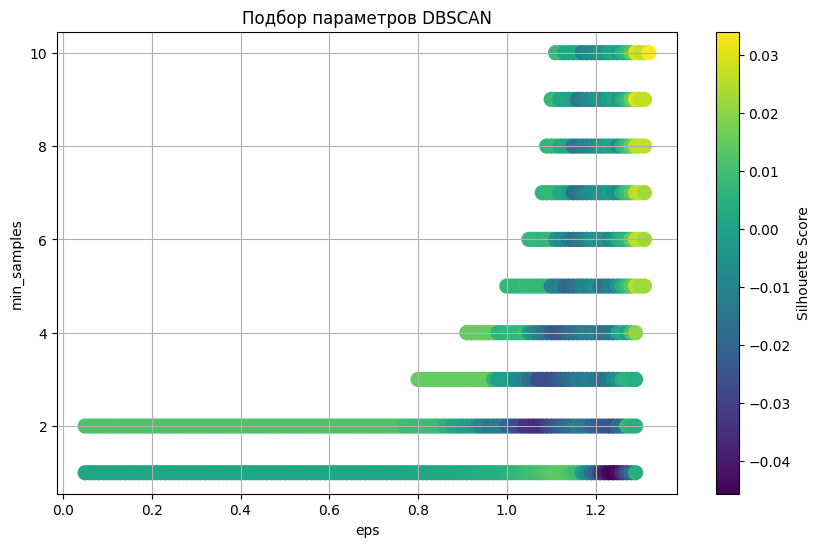

In [156]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Подбор параметров
def find_optimal_params(X):
    # Определяем диапазоны для eps и min_samples
    eps_values = np.arange(0.05, 3.1, 0.01)
    min_samples_values = range(1, 11)

    best_score = -1
    best_eps = None
    best_min_samples = None

    # Словарь для хранения результатов
    results = {}

    for min_samples in min_samples_values:
        for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Игнорируем шум (метка -1)
            if len(set(labels)) > 1:  # Убедимся, что есть хотя бы один кластер
                score = silhouette_score(X, labels)
                results[(eps, min_samples)] = score

                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    return best_eps, best_min_samples, results

best_eps, best_min_samples, results = find_optimal_params(X)

print(f"Лучшие параметры: eps={best_eps}, min_samples={best_min_samples}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
eps_list, min_samples_list = zip(*results.keys())
scores = list(results.values())

plt.scatter(eps_list, min_samples_list, c=scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Подбор параметров DBSCAN')
plt.grid()
plt.show()


In [214]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.32, min_samples=10)  # Подберите параметры eps и min_samples
clusters = dbscan.fit_predict(X)

# Оценка качества
ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.00012152239206982384
Normalized Mutual Information: 0.001743213123039031


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


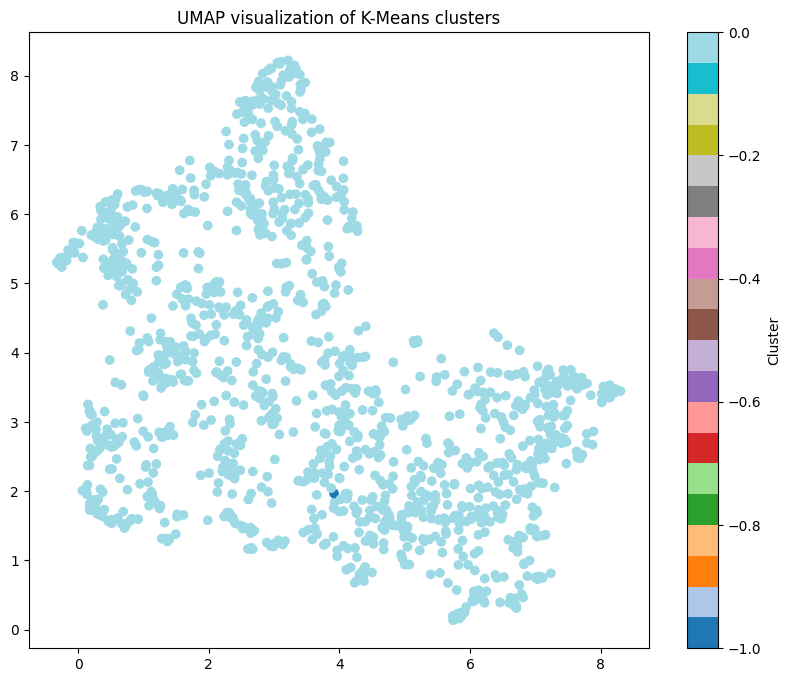

In [158]:
from umap import umap_ as UMAP

# Применяем UMAP для понижения размерности
umap = UMAP.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X.toarray())

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab20', alpha=1.0)
plt.title("UMAP visualization of K-Means clusters")
plt.colorbar(label="Cluster")
plt.show()

DBSCAN просто не сработал, определив лишь одну точку нормально, а все остальные обозвал шумом. DBSCAN — это метод кластеризации, основанный на плотности данных. Он хорошо работает, если данные имеют четко выраженные группы точек, разделенные областями низкой плотности (шумом). Если вы используете векторизацию текста (например, TF-IDF или BERT), данные могут быть высокоразмерными. В таких случаях расстояния между точками становятся менее информативными (проблема "проклятия размерности") и DBSCAN может плохо работать, так как плотность данных в высоких измерениях становится трудно оценить.

### Эмбеддинги BERT

А что если мы попробуем векторизацию не TF-IDF, а BERT?

In [215]:
import torch

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

X = np.array([get_bert_embedding(text) for text in tqdm(filtered_news['truncated_article'])])

100%|██████████| 1385/1385 [03:39<00:00,  6.31it/s]


In [216]:
X = np.array([get_bert_embedding(text).squeeze() for text in tqdm(filtered_news['truncated_article'])])

100%|██████████| 1385/1385 [02:46<00:00,  8.30it/s]


In [217]:
print(X.shape)  # Должно быть (n_samples, embedding_size)

(1385, 312)


In [220]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=num_clusters, random_state=42)
clusters = spectral.fit_predict(X)  # Spectral требует плотной матрицы

# Оценка качества
ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.19852088114636043
Normalized Mutual Information: 0.4383250538998438


In [222]:
from sklearn.cluster import KMeans

# Создаем плоский список всех категорий
all_categories = [category for sublist in filtered_news['categories_final'] for category in sublist]

# Создаем множество уникальных категорий
unique_categories = set(all_categories)

# Количество кластеров равно количеству уникальных категорий
num_clusters = len(unique_categories)

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.24792375443288
Normalized Mutual Information: 0.47394088437221277


Метрики стали получше. Они все еще далеки от идеала, но улучшения видны. Посмотрим где мы ошибаемся

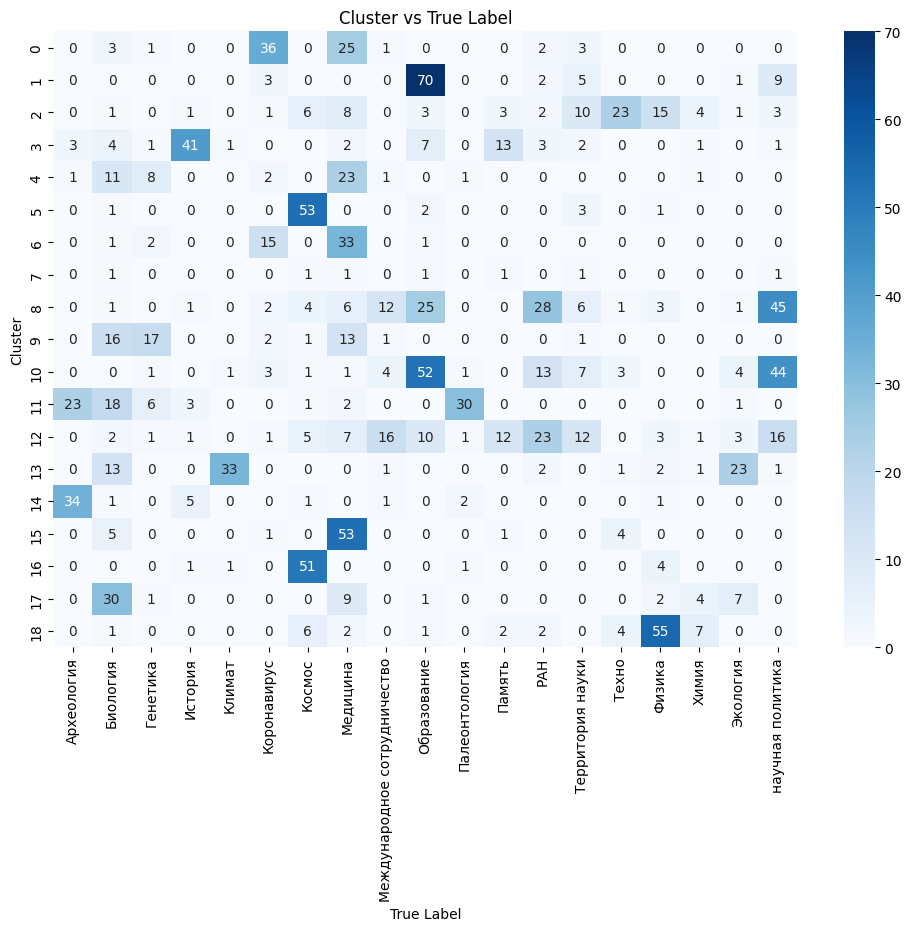

In [223]:
# Создаем DataFrame для анализа ошибок
error_analysis = pd.DataFrame({
    'True_Label': filtered_news['main_category'],
    'Cluster': clusters
})

# Группируем данные по кластерам и истинным меткам
cluster_label_counts = error_analysis.groupby(['Cluster', 'True_Label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_label_counts, annot=True, fmt='d', cmap='Blues')
plt.title("Cluster vs True Label")
plt.xlabel("True Label")
plt.ylabel("Cluster")
plt.show()

В принципе все как и в начале. Имеем 2-3 основных кластера для каждой метки и понемногу в других. 7 кластер практически пуст, а 12 наборот рад видеть у себя всех. Возможно стало немного почище. Посмотрим на визуализацию

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


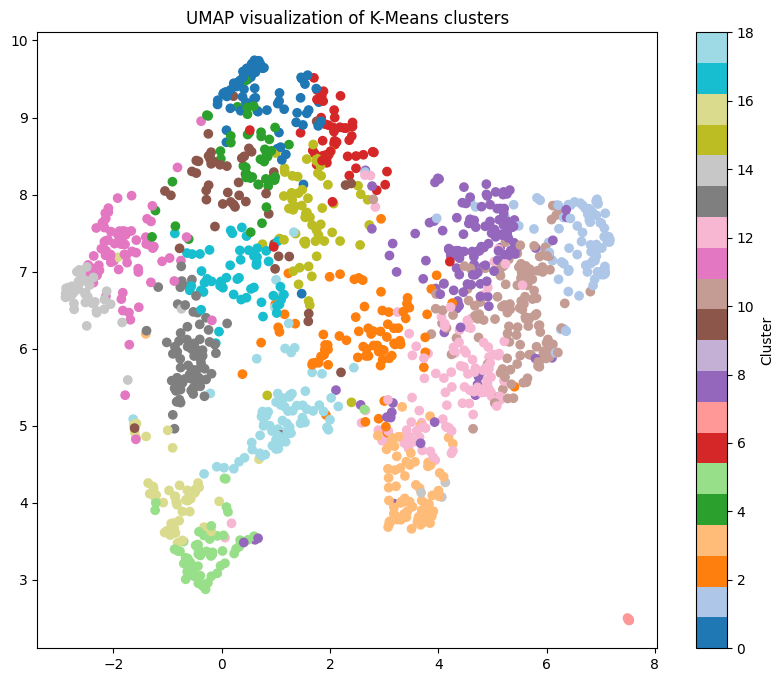

In [224]:
from umap import umap_ as UMAP

# Применяем UMAP для понижения размерности
umap = UMAP.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab20', alpha=1.0)
plt.title("UMAP visualization of K-Means clusters")
plt.colorbar(label="Cluster")
plt.show()

Видно, что кластеры в некоторых местах перемешаны, однако в других местах, особенно в центре и слева/справа, кластеризация удивительно неплоха

In [180]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.32, min_samples=10)  # Подберите параметры eps и min_samples
clusters = dbscan.fit_predict(X)

# Оценка качества
ari = adjusted_rand_score(filtered_news['main_category'], clusters)
nmi = normalized_mutual_info_score(filtered_news['main_category'], clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.0
Normalized Mutual Information: 0.0


DBSCAN все еще не работает

## Бинарный классификатор

Попробуем обучить классификатор на самый большой кластер

In [225]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [226]:
# 1. Выбор кластера
cluster_sizes = Counter(clusters)
largest_cluster = max(cluster_sizes, key=cluster_sizes.get)
print(f"Самый большой кластер: {largest_cluster}, размер: {cluster_sizes[largest_cluster]}")

Самый большой кластер: 8, размер: 135


Наверняка это Медицина или Образование

In [230]:
# Фильтрация новостей по выбранному кластеру
cluster_indices = [i for i, c in enumerate(clusters) if c == largest_cluster]
cluster_news = filtered_news.iloc[cluster_indices].reset_index(drop=True)

# 2. Подготовка данных
X_cluster = X[cluster_indices]
y = cluster_news['main_category']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_cluster, y, test_size=0.3, random_state=42
)

In [231]:
# 3. Обучение классификатора
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

F1-score: 0.4326751838946961


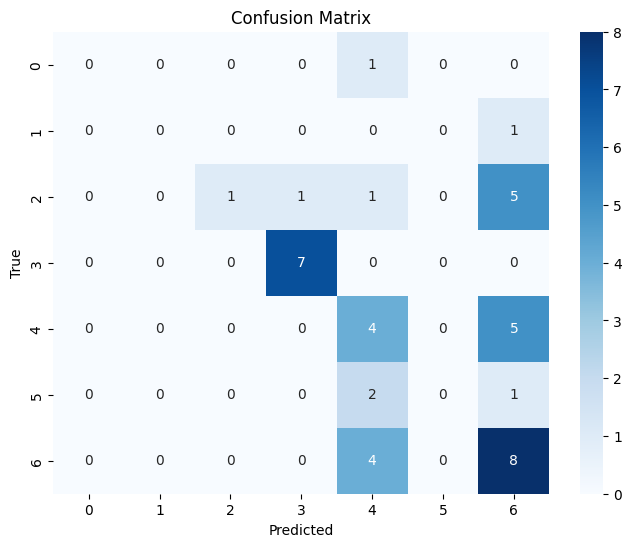

In [232]:
# 4. Оценка качества
y_pred = classifier.predict(X_test)

# F1-мера
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Логистическая регрессия ожидаемо плоха, на визуализации мы убедились, что линейно разделить наши данные очень сложно. Судя по тому, что мы имеем матрицу из 7 классов, это больше похоже на Медицину. А что если попробовать обучиться на Образование, взяв модель помощнее?

In [233]:
# 1. Выбор второго по размеру кластера
cluster_sizes = Counter(clusters)
sorted_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)
second_largest_cluster = sorted_clusters[1][0]
print(f"Второй по размеру кластер: {second_largest_cluster}, размер: {sorted_clusters[1][1]}")

# Фильтрация новостей по выбранному кластеру
cluster_indices = [i for i, c in enumerate(clusters) if c == second_largest_cluster]
cluster_news = filtered_news.iloc[cluster_indices].reset_index(drop=True)

Второй по размеру кластер: 10, размер: 135


In [236]:
# 2. Подготовка данных
X_cluster = X[cluster_indices]
y = cluster_news['main_category']  # Для одноклассовой классификации

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_cluster, y, test_size=0.3, random_state=42
)

In [237]:
from sklearn.ensemble import RandomForestClassifier
# Обучение Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

F1-score (Random Forest): 0.5351118694016829


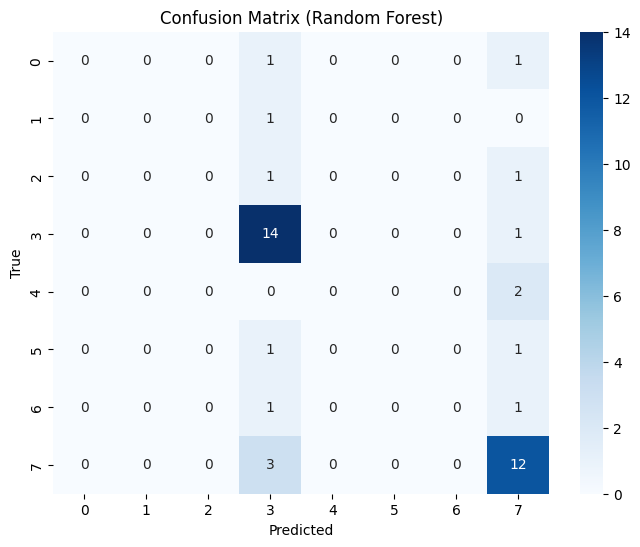

In [239]:
y_pred_rf = rf_classifier.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"F1-score (Random Forest): {f1_rf}")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Матрица ошибок стала более однозначной, однако разделила данные на два класса практически поровну, и добавила немного шума. Данные сложные, категории пересекаются, и обучить классификатор сложно

## Выводы

У наших данных очень неспецифические категории, сильно пересекающиеся друг с другом. Медицина, Генетика, Биология и Климат плавно перетекают друг в друга, сильно осложняя как кластеризацию, так и классификацию. Нужна более тонкая работа с данными, либо нужны данные с лучшей разметкой